# Modelo de Detección de Fraude

Durante el siguiente script se detallan e implementan los pasos para la creación de un modelo de detección de fraude a partir de características de cada una de las transacciones registradas.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

In [2]:
pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation


RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = True

# import os

# if(IS_LOCAL):
#     PATH="../input/credit-card-fraud-detection"
# else:
#     PATH="../input"
# print(os.listdir(PATH))

PATH = 'datos_fraud.csv' #definimos la ruta al archivo, en este caso lo tenemos en la misma carpeta.

# Exploratory Data Analysis (EDA)

Nos encargamos de cargar los datos y vemos en que consisten y que columnas podrán ayudarnos a alimentar el modelo.

Se leen los datos

In [3]:
data_df = pd.read_csv(PATH)

El dataset se compone de un identificador unico para cada transacción, una marca de tiempo, un monto de la transacción, 32 variables númericas y un identicador que distingue entre las dos clases a cada registro.

In [4]:
data_df.head()

,transaction_id,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,variable_08,variable_09,variable_10,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,variable_18,variable_19,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,is_fraud
0,99899e9e02c4b41fc442744220e6fa12f8d36b26f70027...,155270.0,12.00,-0.071330,-0.032900,0.109989,0.339889,-0.626131,-0.116853,1.220826,0.394041,0.051705,0.700084,-1.185263,-0.183050,1.051029,0.267423,-0.220569,1.358207,-0.321922,-1.121246,0.852400,-0.635935,-0.445327,-0.251412,-0.989219,-0.168169,-1.054944,-1.603176,-0.616640,2.283078,0.373964,1.576543,-0.941557,-0.105280,0
1,d678605da2ed45d14c95228b2e6a0daa1c635c7c5d3f7c...,46054.0,208.89,0.057858,0.003669,0.076745,0.392782,0.458835,-0.279094,0.435257,0.230350,0.292049,0.624199,0.327219,-0.032708,-0.372193,1.440826,-0.049183,-0.595081,0.376050,-0.518996,-1.245331,2.034140,-0.073293,-0.439827,-0.863551,-1.606923,-1.100937,0.597263,-1.228029,0.875399,0.260934,-0.558290,0.763729,0.011740,0
2,5f178ebbecf592c3ea98b5b26ff3547f8a40e88aa428d5...,167866.0,1.00,-0.002449,0.019520,-0.038565,0.400659,-1.214922,-0.177434,0.303247,0.030461,-0.112687,-0.307426,1.595186,1.385215,1.068869,1.133506,-2.619782,0.277352,-0.512077,-0.713025,-1.201109,0.561721,-0.351699,0.362076,-1.215083,1.044934,0.533274,-2.802382,0.570268,2.121604,-0.131120,1.603304,-0.032323,0.062465,0
3,455543a8012484e430efd18300186319bf8da376811333...,163539.0,15.00,-0.039202,-0.031762,-0.328682,-0.045094,0.606368,0.204822,0.014322,0.013439,0.016800,0.861519,-0.891606,1.139910,1.179129,-0.795164,-1.056983,-0.142009,-0.026496,1.408220,0.446607,-0.791305,-0.159512,-0.300838,-0.787018,0.020468,-0.853713,-1.915028,-0.478400,2.161957,-1.117518,1.768693,-0.517470,-0.101639,0
4,d8637ef4c5c833fee92149b5b8ef2fad601196be9b7c89...,153872.0,0.01,-0.058206,-0.051926,0.653525,-0.387901,0.806301,0.227390,0.676840,0.209482,-0.206405,0.367224,0.721541,-0.713888,0.496167,0.629590,0.325217,-0.947716,0.513088,0.854643,-0.175665,1.449330,0.141885,-0.854064,-0.347373,-0.750013,-0.914675,-0.595874,-0.705751,2.026529,2.221984,0.744251,-0.768323,-0.166163,0


In [5]:
# Vemos los tipos de datos de cada una de las columnas del dataframe
data_df.describe()

,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,variable_08,variable_09,variable_10,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,variable_18,variable_19,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,is_fraud
count,284807.000000,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,94813.859575,88.349619,-1.247286e-16,-3.675372e-16,1.687909e-15,5.135217e-16,4.471943e-15,2.633534e-16,-3.505225e-16,1.626624e-16,6.452607e-16,1.037596e-15,9.708849e-16,-3.755206e-16,1.434136e-15,4.887206e-15,1.210587e-15,8.243889e-16,-1.247361e-15,1.699373e-15,2.236932e-15,-2.411096e-15,1.147618e-16,-5.633807e-16,1.497617e-15,1.007309e-15,2.095151e-15,-1.401416e-15,3.384974e-16,1.177057e-15,5.730855e-15,2.153892e-15,-1.611056e-15,-1.168774e-15,0.001727
std,47488.145955,250.120109,3.300833e-01,4.036325e-01,4.822270e-01,5.212781e-01,6.056471e-01,6.244603e-01,7.257016e-01,7.345240e-01,7.709250e-01,8.140405e-01,8.381762e-01,8.493371e-01,8.762529e-01,9.153160e-01,9.585956e-01,9.952742e-01,9.992014e-01,1.020713e+00,1.088850e+00,1.098632e+00,1.194353e+00,1.237094e+00,1.332271e+00,1.380247e+00,1.415869e+00,1.516255e+00,1.651309e+00,1.958696e+00,1.639572e+00,1.314379e+00,4.357099e+00,1.291624e+00,0.041527
min,0.000000,0.000000,-1.543008e+01,-2.256568e+01,-2.604551e+00,-1.029540e+01,-2.836627e+00,-4.480774e+01,-1.093314e+01,-3.483038e+01,-5.449772e+01,-7.213527e+00,-9.498746e+00,-2.516280e+01,-1.412985e+01,-4.498945e+00,-1.921433e+01,-5.791881e+00,-1.868371e+01,-4.797473e+00,-2.458826e+01,-1.343407e+01,-7.321672e+01,-4.355724e+01,-2.616051e+01,-1.137433e+02,-5.683171e+00,-4.832559e+01,-7.271573e+01,-5.640751e+01,-8.855472e+00,-2.119478e+01,-2.036771e+02,-7.221017e+01,0.000000
25%,54201.500000,5.600000,-5.295979e-02,-7.083953e-02,-3.269839e-01,-3.171451e-01,-3.545861e-01,-1.618463e-01,-5.423504e-01,-2.283949e-01,-2.117214e-01,-4.562989e-01,-4.988498e-01,-4.837483e-01,-4.680368e-01,-5.828843e-01,-4.255740e-01,-6.485393e-01,-4.055715e-01,-7.624942e-01,-5.354257e-01,-6.430976e-01,-2.086297e-01,-5.540759e-01,-7.682956e-01,-6.915971e-01,-8.486401e-01,-8.903648e-01,-5.985499e-01,-9.203734e-01,-1.111745e+00,-7.020552e-01,-6.990693e-01,-2.266865e-01,0.000000
50%,84692.000000,22.000000,1.124383e-02,1.342146e-03,-5.213911e-02,1.659350e-02,4.097606e-02,-1.119293e-02,6.781943e-03,-2.945017e-02,-6.248109e-02,3.734823e-03,-3.636312e-03,-6.567575e-02,6.641332e-02,4.807155e-02,5.060132e-02,-1.356806e-02,1.400326e-01,-3.275735e-02,-9.291738e-02,-5.142873e-02,2.235804e-02,4.010308e-02,-2.741871e-01,-5.433583e-02,-1.984653e-02,1.798463e-01,6.548556e-02,1.810880e-02,-1.772730e-01,9.961998e-02,1.484186e-01,4.294867e-03,0.000000
75%,139320.500000,77.165000,7.827995e-02,9.104512e-02,2.409522e-01,3.507156e-01,4.395266e-01,1.476421e-01,5.285536e-01,1.863772e-01,1.330408e-01,4.589494e-01,5.008067e-01,3.996750e-01,5.232963e-01,6.488208e-01,4.931498e-01,6.625050e-01,6.182380e-01,7.395934e-01,4.539234e-01,5.971390e-01,3.273459e-01,5.704361e-01,3.985649e-01,6.119264e-01,7.433413e-01,1.027196e+00,8.037239e-01,1.315642e+00,8.192374e-01,7.849445e-01,1.033295e+00,2.913444e-01,0.000000
max,172792.000000,25691.160000,3.384781e+01,3.161220e+01,3.517346e+00,7.519589e+00,4.584549e+00,2.252841e+01,1.050309e+01,2.720284e+01,3.942090e+01,5.591971e+00,5.041069e+00,9.253526e+00,1.731511e+01,8.877742e+00,1.052677e+01,7.126883e+00,7.848392e+00,1.201891e+01,2.374514e+01,1.559499e+01,2.000721e+01,1.205895e+02,7.330163e+0

Como vimos en el output anterior, el dataframe esta compuesto por cinco tipos de columnas, de las cuales:

- transaction_id: se trata de un identificador que nos ayuda a diferencias cada conjunto de caracteristicas asociado a un registro
- time_stamp: para nuestro modelo, podemos omitir esta columna pues la hora y fecha en la que se realizo la transacción no afecta necesariamente para saber si es o no un fraude.
- amount: la cantidad de credito que se maneje puede ser importante para el analisis, pues a una cantidad mayor de monto podemos interpretar que podría existir mayor riesgo de fraude.
- variables 1  a la 32: variables propias de la transaccion que nos ayudan directamente como entrada para nuestro modelo. Al ser un ejercicio el significado independiente de cada una de estas variables no es de importancia.
- is_fraud: es la etiqueta con la que sabremos si la transacción es un fraude o no.

Verificamos valores perdidos

In [6]:
total = data_df.isnull().sum().sort_values(ascending = False) #con isnull() mapea los datos nulos o nan a true y todos los demás datos del df a falso, 
# sum() la suma de los valores de la columna (que sera 0) y crea un diccionario con el nombre de la columna y la cantidad de nulos que tiene
percent = (data_df.isnull().sum()/data_df.count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Porcentaje']).transpose()

,transaction_id,timestamp,variable_18,variable_19,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,variable_17,variable_16,variable_15,variable_06,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_07,variable_14,variable_08,variable_09,variable_10,variable_11,variable_12,variable_13,is_fraud
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Porcentaje,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Datos desbalanceados

Al analizar un dataset como este, podremos encontrarnos con que existe cierto desbalanceo entre las clases, es decir, el número de transacciones fraudulentas es mucho menor que las típicas. Esto siguiendo el hecho de que en un problema real así es como se comportaria.

In [7]:
temp = data_df["is_fraud"].value_counts() #cuenta la cantidad para cada uno de valores que existen en la columna
temp.head()

is_fraud
0    284315
1       492
Name: count, dtype: int64

In [8]:
df = pd.DataFrame({'is_fraud': temp.index,'values': temp.values})
#creamos un df exclusivo para representar la cantidad de transacciones fraudulentas contra las que no

trace = go.Bar(
    x = df['is_fraud'],y = df['values'],
    name="Clase Fraude contra Clase Típica - Desbalanceo de datos (Típica = 0, Fraude = 1)",
    marker=dict(color="Blue"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Clase Fraude contra Clase Típica - Desbalanceo de datos (Típica = 0, Fraude = 1)',
          xaxis = dict(title = 'Clase', showticklabels=True), 
          yaxis = dict(title = 'Número de transacciones'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

En este sentido, podemos encontrarnos con varias posibles soluciones al desbalanceo:

* Modificar el dataset: Eliminar datos de la clase típica a partir de un submuestro para igualar la cantidad de muestras en cada clase. La clara desventaja de este enfoque recae en que la perdida de datos es muy grande.

* Creación de datos artificiales: Crear muestras artificiales, agrandando el conjunto de la clase minoritaria. Procediendo asi sobre esta podemos llegar a alterar la distribución original de los datos y provocar que nuestro modelo sea inutil para crear clasificaciones en un entorno real.

* Balanced Ensemble Method: Combina los resultados de varios modelos del data set y asi obtener la clasificación más 'votada' entre estos.


Transacciones en el tiempo

In [9]:
data_df.loc[data_df['is_fraud'] == 0]["timestamp"]

0         155270.0
1          46054.0
2         167866.0
3         163539.0
4         153872.0
            ...   
284802     67750.0
284803     44849.0
284804    117797.0
284805    167436.0
284806    150148.0
Name: timestamp, Length: 284315, dtype: float64

In [10]:
class_0 = data_df.loc[data_df['is_fraud'] == 0]["timestamp"]# trae todos los registros que no son fraudes, pero solo su timestamp
class_1 = data_df.loc[data_df['is_fraud'] == 1]["timestamp"]# trae todos los registros que son fraudes, peor solo su timestamp

hist_data = [class_0, class_1]
group_labels = ['Típica', 'Fraude']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Diagrama de densidad de transacciones contra tiempo', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [11]:
data_df['Hour'] = data_df['timestamp'].apply(lambda x: np.floor(x / 3600))#se crea un nuevo campo hora que divide el time stamp en horas 


In [12]:

tmp = data_df.groupby(['Hour', 'is_fraud'])['amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
# agrupa por hora y por clase, saca solo el monto y genera las funciones de agregacion 
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


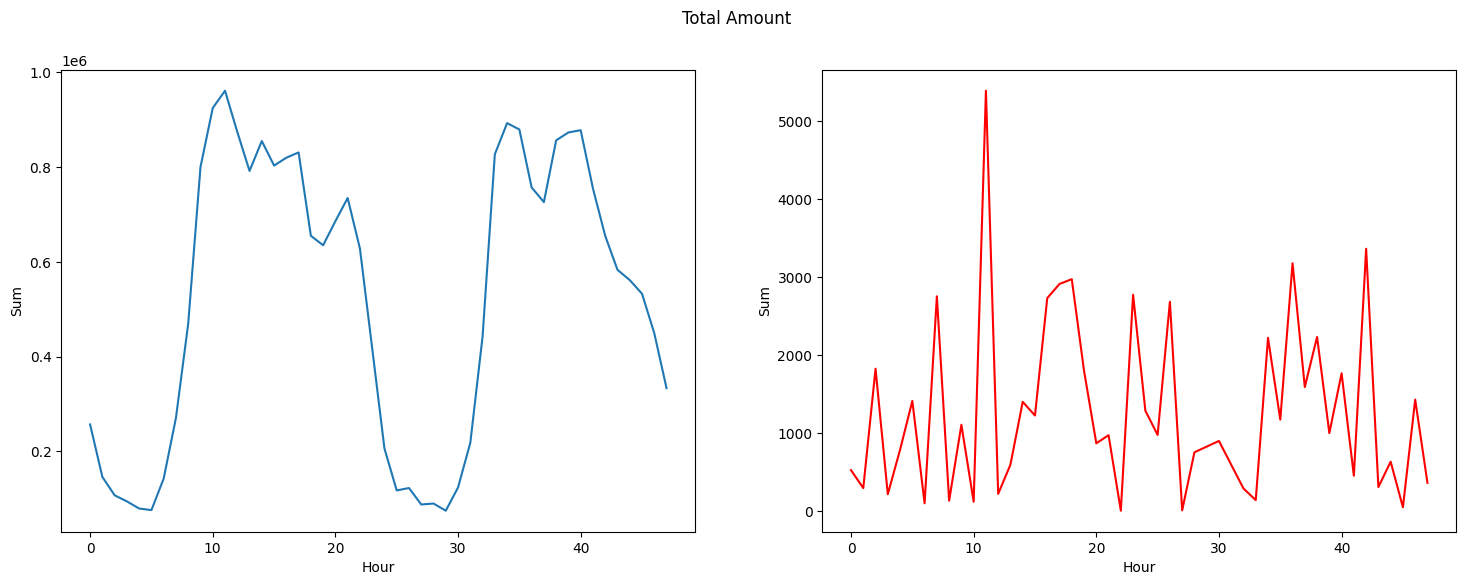

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Monto total")
plt.show();

# Correlación entre las variables:

La correlación entre un par de variables se sustenta en la relación entre ambas. Se dice que si una variale X crece conforme crece una variable Y lo hace, ambas tienen una correlación positiva. Caso contrario si una variable X decrece en relación a una variable Y tienen un correlación negativa. Si en general, no parece haber relación entre las variables y parece que estas fueran en comportamiento independientes una de la otra, entonces las variables no estan correlacionadas.

A continuación se muestra una matriz de correlación entre cada una de las variables del dataset.

In [16]:
#plt.figure(figsize = (14,14))
#plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.loc[:, data_df.columns != 'transaction_id'].corr('pearson')
#sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
corr.style.background_gradient(cmap='coolwarm')
#plt.show()

,timestamp,amount,variable_01,variable_02,variable_03,variable_04,variable_05,variable_06,variable_07,variable_08,variable_09,variable_10,variable_11,variable_12,variable_13,variable_14,variable_15,variable_16,variable_17,variable_18,variable_19,variable_20,variable_21,variable_22,variable_23,variable_24,variable_25,variable_26,variable_27,variable_28,variable_29,variable_30,variable_31,variable_32,is_fraud,Hour
timestamp,1.000000,-0.010596,-0.009413,-0.005135,-0.041407,-0.233083,-0.016182,0.051142,0.144059,0.044736,-0.050866,0.028975,0.090438,-0.073297,0.011903,-0.183453,-0.098757,-0.065902,0.124348,-0.247689,0.030617,-0.008660,-0.036949,0.084714,-0.063016,0.173072,-0.105260,-0.419618,-0.010593,0.117396,-0.041407,0.011903,-0.009413,-0.005135,-0.012323,0.999758
amount,-0.010596,1.000000,0.010258,0.028825,-0.003208,-0.047837,0.005146,-0.112633,-0.064801,0.105999,0.339403,-0.056151,0.035650,0.007309,-0.003910,-0.002986,0.033751,0.005293,-0.009542,0.000104,-0.101502,-0.044246,-0.103079,0.397311,0.215981,-0.386356,0.098732,-0.210880,-0.531409,-0.227709,-0.003208,-0.003910,0.010258,0.028825,0.005632,-0.010673
variable_01,-0.009413,0.010258,1.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,1.000000,-0.000000,0.009536,-0.009434
variable_02,-0.005135,0.028825,-0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,1.000000,0.017580,-0.005216
variable_03,-0.041407,-0.003208,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.004455,-0.041411
variable_04,-0.233083,-0.047837,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.003308,-0.233215
variable_05,-0.016182,0.005146,-0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.007221,-0.016157
variable_06,0.051142,-0.112633,0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002685,0.051192
variable_07,0.144059,-0.064801,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000805,0.144070
variable_08,0.044736,0.105999,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.040413,0.044746


# Modelos Predictivos

In [17]:
target = 'is_fraud'
predictors = ['timestamp', 'variable_01', 'variable_02', 'variable_03', 'variable_04', 'variable_05', 'variable_06', 'variable_07', 'variable_08', 'variable_09', 'variable_10',\
       'variable_11', 'variable_12', 'variable_13', 'variable_14', 'variable_15', 'variable_16', 'variable_17', 'variable_18', 'variable_19',\
       'variable_20', 'variable_21', 'variable_22', 'variable_23', 'variable_24', 'variable_25', 'variable_26', 'variable_27', 'variable_28',\
       'amount']

In [18]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

RandomForestClassifier

Un árbol de desición es un algoritmo de aprendizaje supervisado que divide en subconjuntos el dataset de entrada a partir de crear un nodo inicial o raiz, a partir del cual se irán creando nodos hijos a partir de las caracteristicas del dataser. En cada nodo se quedan los subconjuntos que más se ajusten a la caracteristica de ese nodo.

In [19]:
clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

In [20]:
clf.fit(train_df[predictors], train_df[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [41]:
preds = clf.predict(valid_df[predictors])

C:\Users\MALIERA.ADCONSAR\AppData\Local\Temp\ipykernel_25020\3562096361.py:6: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



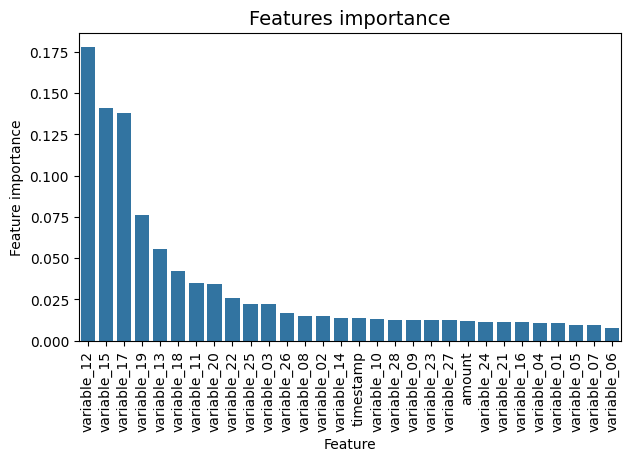

In [42]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()  

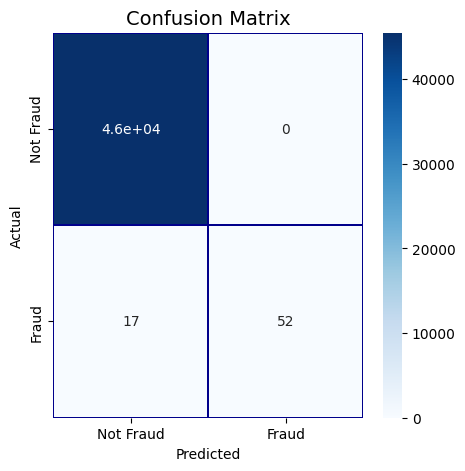

In [43]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [44]:
roc_auc_score(valid_df[target].values, preds)

0.8768115942028986

Para solucionar el problema del desbalanceo en los datos, se realiza un submuestreo.

In [6]:
# Submuestreo aleatorio de la clase mayoritaria (transacciones legítimas)
n_fraud = df.filter(col('is_fraud') == 1).count()
n_legit = df.filter(col('is_fraud') == 0).count()

df_legit_subsampled = df.filter(col('is_fraud') == 0).sample(False, n_fraud / n_legit, seed=42)

# Filtrar las transacciones fraudulentas
df_fraud = df.filter(col('is_fraud') == 1)

# Combinar el subconjunto de transacciones legítimas submuestreado con las transacciones fraudulentas
df = df_legit_subsampled.union(df_fraud)

In [7]:
# Ver estadísticas descriptivas. Ahora el promedio del valor is_fraud es mas cercano a 0.5
df.describe().show()
print(f"numero de muestras: {df.count()}")

+-------+--------------------+-----------------+------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+------------------+-------------------+-------------------+------------------+--------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+
|summary|      transaction_id|        timestamp|            amount|         variable_01|        variable_02|         variable_03|        variable_04|         variable_05|         variable_06|         variable_07|        variable_08|        variable_09|       variable_10|    

Como vemos, el paso de limpieza de datos podemos omitirlo, ya que nuestro dataset no cuenta con datos nulos o incorrectos. 

Para evitar la predominancia de alguna de las caracteristicas en la predicción del modelo, se opta por realizar la normalización de los datos de entrada.

In [8]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

#Convertimos las características en un vector, esto para que las características de cada registro se interpreten como entrada para nuestro
# modelo.
assembler = VectorAssembler(inputCols=[c for c in df.columns if c not in ['transaction_id', 'timestamp', 'is_fraud']], outputCol="features")
df = assembler.transform(df)

# Creamos el MinMaxScaler
min_max_scaler = MinMaxScaler(inputCol="features", outputCol="s_features")
min_max_scaler_model = min_max_scaler.fit(df)
df = min_max_scaler_model.transform(df)


In [9]:
# Seleccionar la variable objetivo y las características.
df = df.select(['transaction_id', 's_features', 'is_fraud'])
df.show()

+--------------------+--------------------+--------+
|      transaction_id|          s_features|is_fraud|
+--------------------+--------------------+--------+
|448eab14ab3be1100...|[0.02253195162451...|       0|
|b3366af5dd24da698...|[0.14005089680930...|       0|
|f64640528d1bc4d50...|[0.01410246158043...|       0|
|d69b16d989f997c4e...|[0.00536251040750...|       0|
|82f6b02e113e27b6a...|[0.00713590200717...|       0|
|2b58a1b1a4353a944...|[0.05484813276446...|       0|
|c655ea515a0ecd105...|[0.03189752901165...|       0|
|8196944079c991dea...|[0.00893281338934...|       0|
|924aaf66f8fa0fc12...|[0.00470395649781...|       0|
|eed3cd952acca5e88...|[0.04322936021487...|       0|
|a839296313a9dce64...|[0.07514100109602...|       0|
|e036495d9ed4b0cce...|[0.01175518728802...|       0|
|84b31c379b7bbdc7d...|[9.97238777535785...|       0|
|844c813a2822c32e1...|[9.31383386566441...|       0|
|7bb47998ec31c4aeb...|[0.13660289669641...|       0|
|4945e4cdd8d706739...|[0.02163819988992...|   

# Justificación

Los árboles de desición son bien conocidos por implementarse en problemás de clasificación. Cada nodo de la estructura que los compone analiza cada caracteristica de las muestras para "tomar" una desición. Es en este sentido por el que se opta por un RandomForest, una generalización del modelo que permite una mejor robustes y resistencia al sobreajuste.

In [10]:
from pyspark.ml.classification import RandomForestClassifier

# Dividimos los datos en conjuntos de entrenamiento y prueba.
train_df, test_df = df.randomSplit([0.7, 0.3], seed=100) #le asignamos un valor a seed para que siempre obtengamos la misma 
                                                        # separación de datos

# Entrenamos el modelo
rf = RandomForestClassifier(labelCol="is_fraud", featuresCol="s_features", numTrees=100) 
model = rf.fit(train_df) # pySpark nos ayuda con la función fit para el entrenamiento automático del modelo

# Realizamos las  predicciones
predictions = model.transform(test_df)
predictions.select("transaction_id","s_features", "is_fraud", "prediction", "probability").show()


+--------------------+--------------------+--------+----------+--------------------+
|      transaction_id|          s_features|is_fraud|prediction|         probability|
+--------------------+--------------------+--------+----------+--------------------+
|4945e4cdd8d706739...|[0.02163819988992...|       0|       0.0|[0.75089884006146...|
|924aaf66f8fa0fc12...|[0.00470395649781...|       0|       0.0|[0.94578088742521...|
|a839296313a9dce64...|[0.07514100109602...|       0|       0.0|[0.74244161706726...|
|c655ea515a0ecd105...|[0.03189752901165...|       0|       0.0|[0.85121720901494...|
|d69b16d989f997c4e...|[0.00536251040750...|       0|       0.0|[0.90095264002227...|
|3a5828ab712552202...|[9.31383386566441...|       0|       0.0|[0.94328070632250...|
|3a5bded1fad7cb8ae...|[0.03101788914656...|       0|       0.0|[0.94084160282494...|
|b606422a35eeb682b...|[4.70395649781030...|       0|       0.0|[0.92633196833539...|
|bb18dc7a39a08b2d5...|[4.18652128305117...|       0|       0.0|[0

# Testing de modelo
Se incluyen medidas tipicas para la evaluación del modelo.

In [11]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# ROC AUC Score
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)
print(f'ROC AUC Score: {roc_auc}')

# Matriz de confusión
predictions.groupBy("is_fraud", "prediction").count().show()

# Precision y Recall
evaluator_precision = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="precisionByLabel")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="recallByLabel")
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# F1 Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)
print(f'F1 Score: {f1_score}')

# Accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator_accuracy.evaluate(predictions)
print(f'Accuracy: {accuracy}')

ROC AUC Score: 0.9687326222132349
+--------+----------+-----+
|is_fraud|prediction|count|
+--------+----------+-----+
|       0|       0.0|  129|
|       0|       1.0|    2|
|       1|       0.0|   19|
|       1|       1.0|  132|
+--------+----------+-----+

Precision: 0.8716216216216216
Recall: 0.9847328244274809
F1 Score: 0.9255796778608611
Accuracy: 0.925531914893617


In [12]:
# Convertir predicciones a un DataFrame de pandas
predictions_pd = predictions.select("transaction_id", "probability").toPandas()
predictions_pd['score'] = predictions_pd['probability'].apply(lambda x: x[1])
#El score representa así, la posibilidad de que la transacción sea fraudulenta
predictions_pd = predictions_pd.drop('probability', axis=1)

# Guardar como CSV
predictions_pd.to_csv('predicciones_fraude.csv', index=False)
